# EDM analytical denoiser - CIFAR10 example

Thanks to Alexia JM for sharing her own implementation from which I could cross-reference and verify with. Despite the supposed simplicity of the closed form denoiser, I found it somewhat painful to debug and implement :( There are no guarantees to the correctness of this code and I have not verified it with the original EDM paper authors.

In [1]:
import math
import numpy as np
import torch
from functools import partial
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Normal

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tqdm.notebook import tqdm
from tqdm import trange

In [3]:
if ".".join(torch.__version__.split(".")[0:2]) == '1.12':
    # In my case I'm using PyTorch 1.12, and therefore I need
    # to install functorch==0.2.0
    from functorch import vmap
    print("PyTorch 1.12 detected")
    print("If necessary, install functorch==0.2.0 via: `pip install functorch==0.2.0 --no-deps`")
elif int(torch.__version__.split(".")[0]) >= 2:
    from torch import vmap
else:
    print("This notebook only supports PyTorch versions 1.12 or >= 2")

PyTorch 1.12 detected
If necessary, install functorch==0.2.0 via: `pip install functorch==0.2.0 --no-deps`


In [4]:
# On PyTorch 1.12 install functorch via the following:
# %pip install functorch==0.2.0 --no-deps

----

## Load dataset

Load entire dataset into memory.

In [9]:
ds = CIFAR10(root="/tmp", download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [10]:
loader = DataLoader(ds, batch_size=50000, shuffle=True)

In [11]:
dataset = iter(loader).next()

In [12]:
#dataset = dataset[0].to(0)

In [13]:
dataset = (dataset[0].to(0) - 0.5) / 0.5

## Plotting fns

In [14]:
def _to_matplot_img(x):
    return x.transpose(0,1).transpose(1,2).numpy()*0.5 + 0.5

In [15]:
dataset.min(), dataset.max()

(tensor(-1., device='cuda:0'), tensor(1., device='cuda:0'))

In [16]:
dataset.shape

torch.Size([50000, 3, 32, 32])

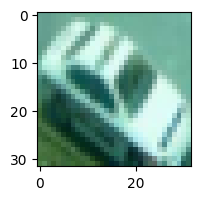

In [17]:
plt.figure(figsize=(2,2))
plt.imshow(_to_matplot_img(dataset[0].cpu()))

-------

## Implementation

See Appendix B.3 of [EDM](https://arxiv.org/abs/2206.00364).

We can construct a kernel density-based estimate of the score function via the following:

$$ D(x; \sigma) \approx \frac{\sum_i \mathcal{N}(x; y_i, \sigma^2)y_i}{\sum_i \mathcal{N}(x; y_i, \sigma^2)} = \frac{1}{Z_{\mathcal{D}}} \sum_i \mathcal{N}(x; y_i, \sigma^2) y_i $$

where $\{ y_i \}_{i=1}^{N}$ are your samples from the ground truth distn and $Z_{\mathcal{D}}$ is the normalisation constant.

In [21]:
def pdf(x: torch.FloatTensor, loc: torch.FloatTensor, scale: torch.FloatTensor):
    var = scale**2
    logits = -((x - loc) ** 2) / scale**2
    return torch.exp(logits)

In [22]:
def logpdf(x: torch.FloatTensor, loc: torch.FloatTensor, scale: torch.FloatTensor):
    var = scale**2
    logits = -((x - loc) ** 2) / scale**2
    return logits

In [23]:
def denoiser(x: torch.FloatTensor, noise: float, data: torch.FloatTensor,  temp: float = 1.0 ):
    """x should not have a batch dimension here"""
    #print(x.shape, noise, data.shape)
    assert len(x.shape) == 3
    x_orig = x[None]
    noise = torch.FloatTensor([noise]).to(x.device)
    x = x[None].repeat(data.size(0), 1, 1, 1)
    
    # The more mathematically correct thing is to take the sum inside the logpdf 
    # (not the mean) but this just means we do $\exp(\text{-ve extremely large number})$ 
    # which gives us zero.
    pdf_per_data = torch.exp(logpdf(
        x, loc=data, scale=torch.zeros_like(data)+noise
    ).mean(dim=(1,2,3), keepdims=True))
    
    numerator = (pdf_per_data * data).sum(0, keepdims=True)
    denominator = pdf_per_data.sum(0, keepdims=True) 
    result = numerator / (denominator)

    return result[0] #.clip(-1, 1)

### Construct batched version

`denoiser` takes a singleton image (a 3d tensor of shape `(n_ch, h, w)`) given the entire dataset of shape `(N, n_ch, h, w)`, so we need to create a batched version of the function.

In [24]:
denoiser_batched = vmap(partial(denoiser, temp=1.0), in_dims=(0,None,None))

In [25]:
x_batch = dataset[0:1]

In [26]:
vmap_out = denoiser(x_batch[-1], 1., dataset, temp=1.)

In [27]:
vmap_out = denoiser(x_batch[-1], 0.1, dataset, temp=1.)
vmap_out.min(), vmap_out.max()

(tensor(-0.9765, device='cuda:0'), tensor(1., device='cuda:0'))

In [30]:
denoiser(torch.randn_like(x_batch[-1]), 0.1, dataset, temp=1.).min()

tensor(-0.2000, device='cuda:0')

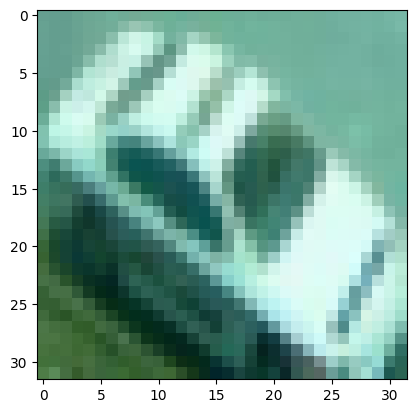

In [29]:
plt.imshow(_to_matplot_img(x_batch[-1].cpu()))

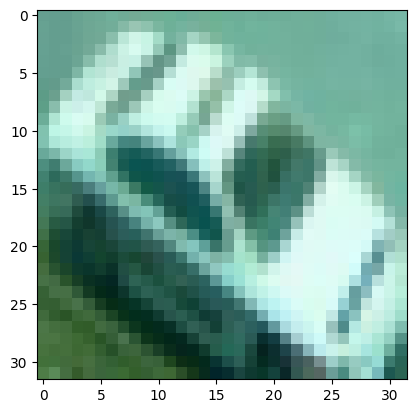

In [31]:
plt.imshow(_to_matplot_img(vmap_out.cpu()))

-----

## Samplers

Going to use Katherine Crowson's neat implementation of Alg 2 [here](https://github.com/comfyanonymous/ComfyUI/blob/eda87043862f743b0a0467735f8531f7c4709b3a/comfy/k_diffusion/sampling.py#L127-L144) (slightly modified) as well as her useful helper functions.

In [32]:
@torch.no_grad()
def sample_euler_analytical(model, x, sigmas, extra_args=None, callback=None, disable=None, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    """Implements Algorithm 2 (Euler steps) from Karras et al. (2022).
    
    Modified to directly take in score function, not denoiser.
    """
    extra_args = {} if extra_args is None else extra_args
    for i in trange(len(sigmas) - 1, disable=disable):
        denoised = model(x, sigmas[i], extra_args)
        d = to_d(x, sigmas[i], denoised)
        #print("{}: denoised norm={:.3f}".format(i, (denoised**2).mean()))
        if callback is not None:
            callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigma_hat, 'denoised': denoised})
        dt = sigmas[i + 1] - sigmas[i]
        #print(dt)
        # Euler method
        x = x + d * dt
    return x

In [33]:
def append_dims(x, target_dims):
    """Appends dimensions to the end of a tensor until it has target_dims dimensions."""
    dims_to_append = target_dims - x.ndim
    if dims_to_append < 0:
        raise ValueError(f'input has {x.ndim} dims but target_dims is {target_dims}, which is less')
    return x[(...,) + (None,) * dims_to_append]

In [34]:
def to_d(x, sigma, denoised):
    """Converts a denoiser output to a Karras ODE derivative."""
    return (x - denoised) / append_dims(sigma, x.ndim)

In [35]:
def append_zero(x):
    return torch.cat([x, x.new_zeros([1])])

In [36]:
def get_sigmas_karras(n, sigma_min, sigma_max, rho=7., device='cpu'):
    """Constructs the noise schedule of Karras et al. (2022)."""
    ramp = torch.linspace(0, 1, n, device=device)
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return append_zero(sigmas).to(device)

### Test noise schedule code

In [37]:
sigmas = get_sigmas_karras(n=100, sigma_min=0.002, sigma_max=1.0, rho=10.0)
#sigmas2 = get_sigmas_karras(n=200, sigma_min=, sigma_max=10., rho=1.0)

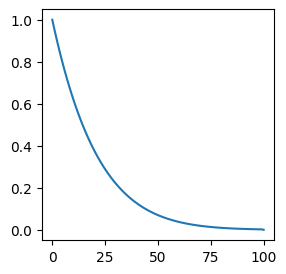

In [38]:
plt.figure(figsize=(3,3))
plt.plot(sigmas)
#plt.plot(sigmas2)

------

## Generate samples

In [39]:
def sample_q(x, sigma):
    noise = torch.zeros_like(x).normal_(0,1)
    x_t =  x + sigma*noise
    #if normalise:
    #    x_t = x_t / sigma
    return x_t

In [40]:
def sample_prior(x, sigma=1.):
    return torch.zeros_like(x).normal_(0,sigma)

### Sample from forward process

Sample from $x_{t} \sim p(x; \sigma_t)$ and denoise.

In [41]:
rnd_idc = np.random.randint(0, len(dataset))

For $\sigma_{\text{min}} = 0.01$ it seems like we just recover a real example from the training set even at high noise levels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


trying: sigma = 0.05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.9608, device='cuda:0') tensor(0.8196, device='cuda:0')
trying: sigma = 0.25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.5529, device='cuda:0') tensor(0.5843, device='cuda:0')
trying: sigma = 0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.5529, device='cuda:0') tensor(0.5843, device='cuda:0')
trying: sigma = 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.5216, device='cuda:0') tensor(0.7490, device='cuda:0')
trying: sigma = 5.0
tensor(-0.5137, device='cuda:0') tensor(0.3569, device='cuda:0')


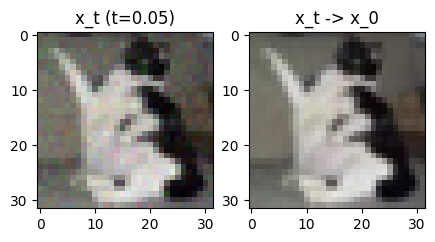

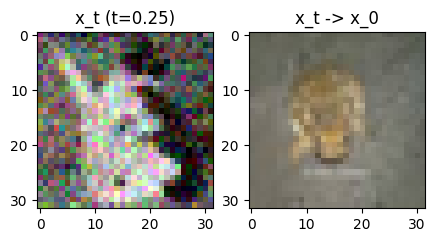

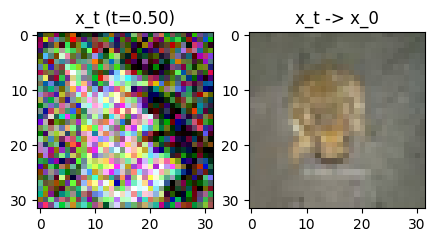

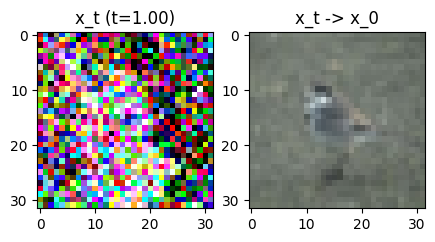

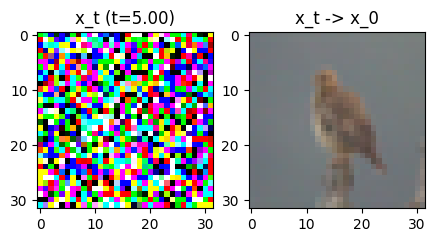

In [42]:
#for sigma_test in np.linspace(0.0, 0, num=5):
SIGMA_MIN = 0.01
for sigma_test in [0.05, 0.25, 0.5, 1., 5.]:
    
    print("trying: sigma =", sigma_test)
    
    #x_t = sample_prior(dataset[0:1], sigma_test)
    x_t = sample_q(dataset[rnd_idc:rnd_idc+1], sigma_test)
    sigmas = get_sigmas_karras(n=100, sigma_min=SIGMA_MIN, sigma_max=sigma_test, rho=7.0)
    sigmas = sigmas.to(x_t.device)
    
    #print(x_t.min(), x_t.max())
    
    fig, axes = plt.subplots(1, 2, figsize=(5,3))
    axes[0].imshow( 
        _to_matplot_img( 
            #torch.clamp(x_sample, 0, 1).cpu()[-1]
            #latent.cpu()[0]*0.5 + 0.5,
            x_t.cpu()[0]
        ) 
    )
    axes[0].set_title("x_t (t={:.2f})".format(sigma_test))
    
    x_t_denoised = sample_euler_analytical(
        denoiser_batched, x_t, sigmas, extra_args=dataset, 
    )
    
    print(x_t_denoised.min(), x_t_denoised.max())
    
    axes[1].imshow( 
        _to_matplot_img( 
            #torch.clamp(x_sample, 0, 1).cpu()[-1]
            x_t_denoised.cpu()[0]
        ),
        #vmin=x_t_denoised.min(),
        #vmax=x_t_denoised.max()
    )
    axes[1].set_title("x_t -> x_0")

Try $\sigma_{\text{min}} = 0.1$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


trying: sigma = 0.05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.9608, device='cuda:0') tensor(0.8196, device='cuda:0')
trying: sigma = 0.25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.3795, device='cuda:0') tensor(0.1543, device='cuda:0')
trying: sigma = 0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.3129, device='cuda:0') tensor(0.0476, device='cuda:0')
trying: sigma = 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.2579, device='cuda:0') tensor(0.0222, device='cuda:0')
trying: sigma = 5.0
tensor(-0.2543, device='cuda:0') tensor(0.0164, device='cuda:0')


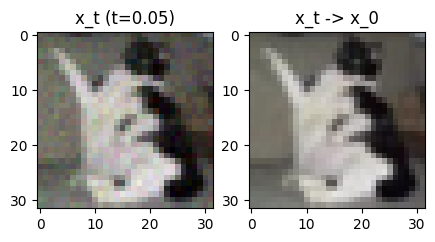

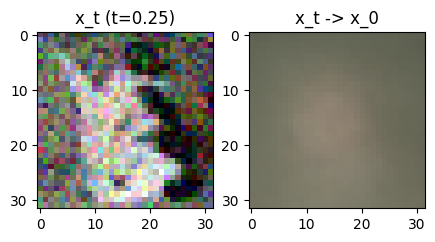

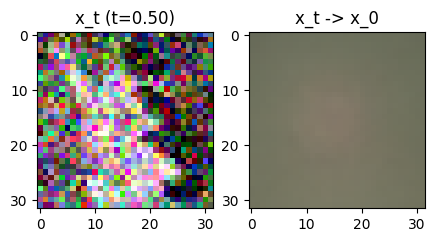

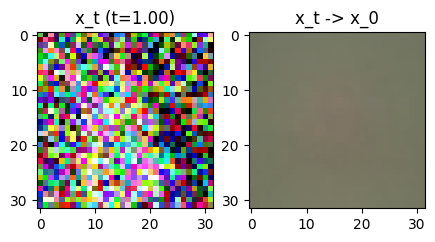

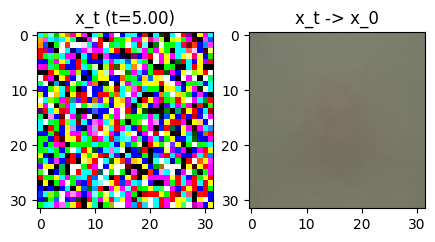

In [43]:
#for sigma_test in np.linspace(0.0, 0, num=5):
SIGMA_MIN = 0.1
for sigma_test in [0.05, 0.25, 0.5, 1., 5.]:
    
    print("trying: sigma =", sigma_test)
    
    #x_t = sample_prior(dataset[0:1], sigma_test)
    x_t = sample_q(dataset[rnd_idc:rnd_idc+1], sigma_test)
    sigmas = get_sigmas_karras(n=100, sigma_min=SIGMA_MIN, sigma_max=sigma_test, rho=7.0)
    sigmas = sigmas.to(x_t.device)
    
    #print(x_t.min(), x_t.max())
    
    fig, axes = plt.subplots(1, 2, figsize=(5,3))
    axes[0].imshow( 
        _to_matplot_img( 
            #torch.clamp(x_sample, 0, 1).cpu()[-1]
            #latent.cpu()[0]*0.5 + 0.5,
            x_t.cpu()[0]
        ) 
    )
    axes[0].set_title("x_t (t={:.2f})".format(sigma_test))
    
    x_t_denoised = sample_euler_analytical(
        denoiser_batched, x_t, sigmas, extra_args=dataset, 
    )
    
    print(x_t_denoised.min(), x_t_denoised.max())
    
    axes[1].imshow( 
        _to_matplot_img( 
            #torch.clamp(x_sample, 0, 1).cpu()[-1]
            x_t_denoised.cpu()[0]
        ),
        #vmin=x_t_denoised.min(),
        #vmax=x_t_denoised.max()
    )
    axes[1].set_title("x_t -> x_0")

### Sample from prior

Sample $x_t \sim p(x_t) = \mathcal{N}(x_t; 0, \sigma_{\text{max}})$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'x_T -> x_0')

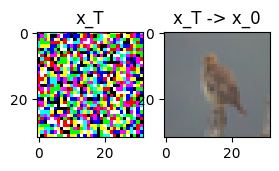

In [44]:
#x_t = sample_q(dataset[rnd_idc:rnd_idc+1], sigma=sigma_test) #normalise=True)

s_prior = 80.

x_T = sample_prior(dataset[1:2], s_prior)

sigmas = get_sigmas_karras(n=100, sigma_min=0.01, sigma_max=s_prior, rho=7.0).to(x_T.device)

fig, axes = plt.subplots(1, 2, figsize=(3,2))
axes[0].imshow( 
    _to_matplot_img( 
        #torch.clamp(x_sample, 0, 1).cpu()[-1]
        #latent.cpu()[0]*0.5 + 0.5,
        x_T.cpu()[0]
    ) 
)
axes[0].set_title("x_T")
x_T_denoised = sample_euler_analytical(denoiser_batched, x_T, sigmas, extra_args=dataset)

#x_t_denoised = (x_t_denoised - x_t_denoised.min()) / (x_t_denoised.max() - x_t_denoised.min())
#x_t_denoised = (x_t_denoised - 0.5) / 0.5

axes[1].imshow( 
    _to_matplot_img( 
        #torch.clamp(x_sample, 0, 1).cpu()[-1]
        x_T_denoised.cpu()[0]
    ) 
)
axes[1].set_title("x_T -> x_0")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'x_T -> x_0')

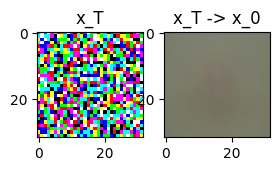

In [45]:
#x_t = sample_q(dataset[rnd_idc:rnd_idc+1], sigma=sigma_test) #normalise=True)

s_prior = 80.

x_T = sample_prior(dataset[1:2], s_prior)

sigmas = get_sigmas_karras(n=100, sigma_min=0.1, sigma_max=s_prior, rho=7.0).to(x_T.device)

fig, axes = plt.subplots(1, 2, figsize=(3,2))
axes[0].imshow( 
    _to_matplot_img( 
        #torch.clamp(x_sample, 0, 1).cpu()[-1]
        #latent.cpu()[0]*0.5 + 0.5,
        x_T.cpu()[0]
    ) 
)
axes[0].set_title("x_T")
x_T_denoised = sample_euler_analytical(denoiser_batched, x_T, sigmas, extra_args=dataset)

axes[1].imshow( 
    _to_matplot_img( 
        #torch.clamp(x_sample, 0, 1).cpu()[-1]
        x_T_denoised.cpu()[0]
    ) 
)
axes[1].set_title("x_T -> x_0")